In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random
import math
import time
random.seed(0)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/are-sd-2025-classification-diagnostique-d-arbres/benchmark.csv
/kaggle/input/are-sd-2025-classification-diagnostique-d-arbres/prev.csv
/kaggle/input/are-sd-2025-classification-diagnostique-d-arbres/train.csv


In [2]:
#Chargement des tableaux

data = pd.read_csv('/kaggle/input/are-sd-2025-classification-diagnostique-d-arbres/train.csv', index_col = 'ID_ARBRE')
prev_data = pd.read_csv('/kaggle/input/are-sd-2025-classification-diagnostique-d-arbres/prev.csv', index_col = 'ID_ARBRE')

data.head()

,quartier,site,genre_arbre,situation,type_sol,surf_permeable,classe_age,hauteur,classe_hauteur,diametre,...,fissure_houppier,ecorce_incluse_houppier,bois_mort_houppier,plaie_houppier,observation_houppier,esperance_maintien,contrainte,classification_diagnostic,Long,Lat
ID_ARBRE,,,,,,,,,,,,,,,,,,,,,
0,Quartier 3 - Lycée International,RN13,Tilia,Alignement,MA,4.0,A,500,H1,31.830989,...,HPF,Non,HPBM,HPLS,0,1.0,Non,C1,2.064,48.900
1,Quartier 2 - Alsace - Pereire,Avenue du Maréchal Foch,Tilia,Alignement,MA,4.0,A,800,H2,76.394373,...,HFO,Non,HPBM,HPLNC,Fissure ouverte axe2 2M Sud Est,2.0,Oui,C4,2.085,48.903
2,Quartier 2 - Alsace - Pereire,RN13,Tilia,Alignement,GR,4.0,A,500,H1,38.197186,...,HPF,Non,HPBM,HPLS,0,1.0,Non,C1,2.070,48.899
3,Quartier 1 - Cœur de Ville et Quatier forestier,Avenue Gambetta,Tilia,Alignement,Gr,1.0,A,600,H2,66.845076,...,HPF,Non,HPBM,HPLS,Branches cassées,1.0,Non,C2,2.099,48.897
4,Quartier 1 - Cœur de Ville et Quatier forestier,Rue Thiers,Cercis,Isolé,MA,20.0,JA,400,H1,25.464791,...,HPF,Non,HPBM,HPPL,0,1.0,Non,C2,2.101,48.898


# Données issues du tableau

In [3]:
#Nombre d'arbres dans data et dans prev_data

len(data), len(prev_data)

(544, 137)

In [4]:
#Colonnes du tableau et leur type

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 544 entries, 0 to 558
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   quartier                   544 non-null    object 
 1   site                       544 non-null    object 
 2   genre_arbre                544 non-null    object 
 3   situation                  544 non-null    object 
 4   type_sol                   544 non-null    object 
 5   surf_permeable             544 non-null    float64
 6   classe_age                 544 non-null    object 
 7   hauteur                    544 non-null    int64  
 8   classe_hauteur             544 non-null    object 
 9   diametre                   544 non-null    float64
 10  circonference (en cm)      544 non-null    int64  
 11  classe_circonference       544 non-null    object 
 12  port_arbre                 544 non-null    object 
 13  vigueur_pousse             544 non-null    object 
 14 

In [5]:
#Nombre d'arbres de classification C1

np.sum(data['classification_diagnostic'] == 'C1')

185

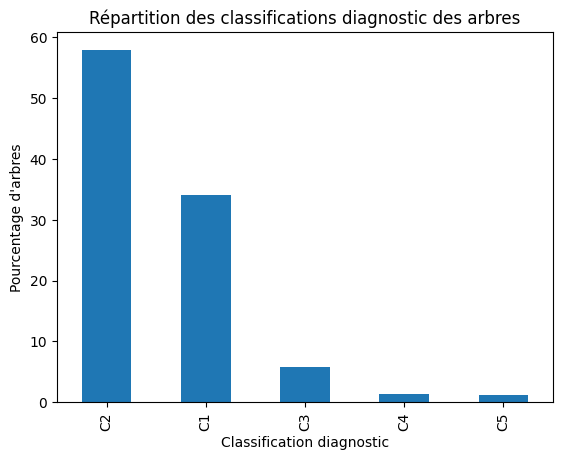

In [6]:
#Répartition des classifications des arbres en pourcentages

(100 * data['classification_diagnostic'].value_counts() / len(data)).plot.bar()
plt.title("Répartition des classifications diagnostic des arbres")
plt.xlabel("Classification diagnostic")
plt.ylabel("Pourcentage d'arbres")
plt.show()

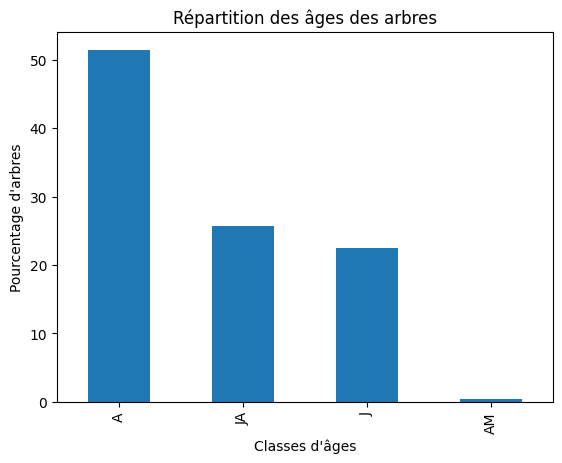

In [7]:
#Répartition des âges des arbres en pourcentages

(100 * data['classe_age'].value_counts() / len(data)).plot.bar()
plt.title("Répartition des âges des arbres")
plt.xlabel("Classes d'âges")
plt.ylabel("Pourcentage d'arbres")
plt.show()

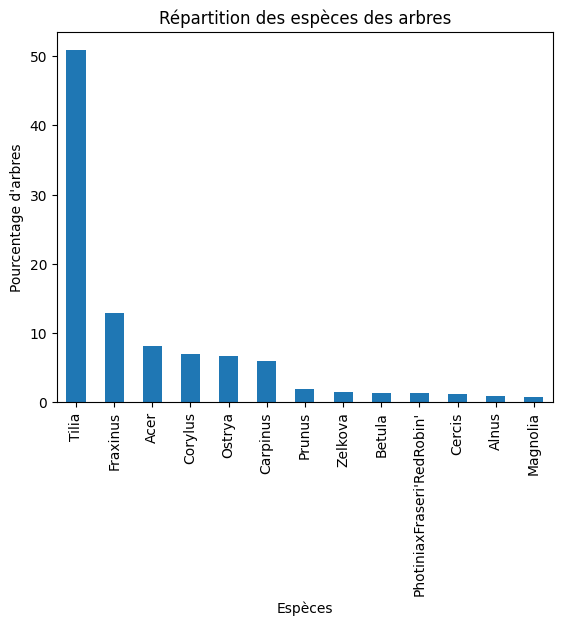

In [8]:
#Répartition des espèces des arbres en pourcentages

(100 * data['genre_arbre'].value_counts() / len(data)).plot.bar()
plt.title("Répartition des espèces des arbres")
plt.xlabel("Espèces")
plt.ylabel("Pourcentage d'arbres")
plt.show()

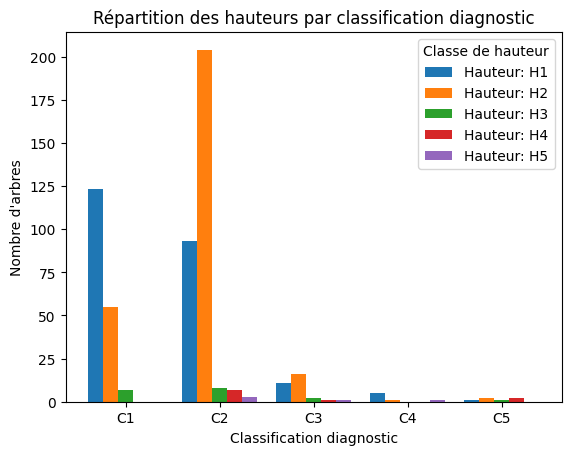

In [9]:
#Répartition des hauteurs par classification_diagnostic

diagnostics = data['classification_diagnostic'].unique()
diagnostics.sort()
hauteur_classes = data['classe_hauteur'].unique()
hauteur_classes.sort()

bar_width = 0.8 / len(hauteur_classes) 
x = np.arange(len(diagnostics))  

for i, hauteur in enumerate(hauteur_classes):
    #Nb d'éléments par hauteur et classe diagnostique
    counts = [ sum((data['classification_diagnostic'] == diag) & (data['classe_hauteur'] == hauteur))
              for diag in diagnostics]
    plt.bar(
        x + i * bar_width, #Expression pour que les barres ne se chevauchent pas
        counts, 
        bar_width, 
        label=f'Hauteur: {hauteur}'
    )

plt.xticks(x + (len(hauteur_classes)-1) * bar_width / 2, diagnostics)  # Centrer les labels sur l'axe x ()
plt.title("Répartition des hauteurs par classification diagnostic")
plt.xlabel("Classification diagnostic")
plt.ylabel("Nombre d'arbres")
plt.legend(title="Classe de hauteur")
plt.show()

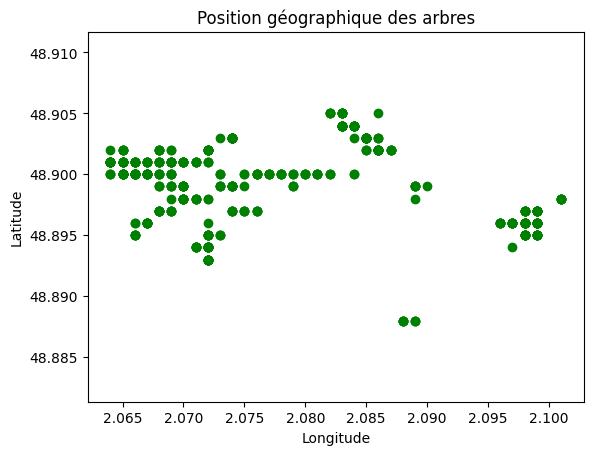

In [10]:
#Position géographique des arbres

plt.scatter(data['Long'], data['Lat'], c = 'green')
plt.axis('equal')
plt.title("Position géographique des arbres")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

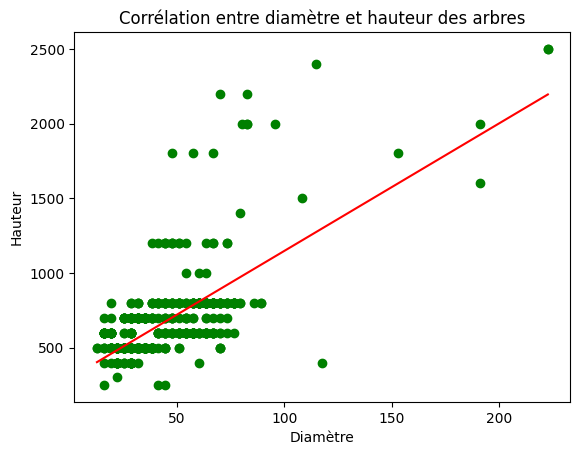

(293.88157053526754, 8.532988476310926)

In [11]:
#Corrélation entre diamètre et hauteur des arbres

x = data['diametre']
y = data['hauteur']
plt.scatter(x, y, c = 'green') #On affiche les données sur un graphe en 2D

b = (np.cov(x,y)[0,1]) / np.var(x)
a = np.mean(y) - b * np.mean(x)
plt.plot([np.min(x), np.max(x)],[a + b * np.min(x), a + b * np.max(x)] , c = 'red') #On calcule la droite qui minimise le
#critère des moindres carrés, c'est a dire la droite qui approche le mieux les données

plt.title("Corrélation entre diamètre et hauteur des arbres")
plt.xlabel("Diamètre")
plt.ylabel("Hauteur")
plt.show()

(a,b)

# Algorithme de Naive Bayes

In [12]:
#Tableau de la classification de chaque arbre

cla_arbres = pd.DataFrame(data, columns = ['classification_diagnostic'])

cla_arbres.head()

,classification_diagnostic
ID_ARBRE,
0,C1
1,C4
2,C1
3,C2
4,C2


In [13]:
#Répartition des arbres selon classification_diagnostic

pY = data['classification_diagnostic'].value_counts(normalize = True)

pY

classification_diagnostic
C2    0.579044
C1    0.340074
C3    0.056985
C4    0.012868
C5    0.011029
Name: proportion, dtype: float64

In [14]:
#Fonction qui établit le tableau de contingence entre classification_diagnostic et une variable v1

def contin(v1) :
    return pd.crosstab(data['classification_diagnostic'], data[v1], normalize = 'index')

contin('classe_age')

classe_age,A,AM,J,JA
classification_diagnostic,,,,
C1,0.313514,0.000000,0.416216,0.270270
C2,0.631746,0.006349,0.133333,0.228571
C3,0.419355,0.000000,0.064516,0.516129
C4,0.714286,0.000000,0.142857,0.142857
C5,0.833333,0.000000,0.000000,0.166667


In [15]:
#Fonction renvoyant la classe majoritaire des arbres ayant a1 comme valeur à la variable v1
#On suppose a1 parmi les valeurs de v1

def classif1(v1, a1) :
    return (contin(v1)[a1] * pY).idxmax() #renvoie l'index de classe la plus fréquente

classif1('classe_age','J')

'C1'

In [16]:
#Naive Bayes à 1 variable, qui s'entraine sur train, et prévoit sur prev, à partir de la variable v1
def bayes1(train, prev, v1) :
    
    #Sélection des "catégories", création du DataFrame
    labels = np.unique(train['classification_diagnostic'])
    df = pd.DataFrame(index = prev.index, columns = ['classification_diagnostic'])
    
    #Obtention de la classe la plus probable grâce à "classif1"
    for i in prev.index :
        df.loc[i, 'classification_diagnostic'] = classif1(v1,prev.loc[i,v1])

    return df

bayes1(data, prev_data, 'classe_hauteur')

,classification_diagnostic
ID_ARBRE,
559,C2
560,C2
561,C2
562,C1
563,C1
...,...
694,C2
695,C1
696,C1


In [17]:
#Fonction renvoyant la classe majoritaire des arbres ayant a1 comme valeur à la variable v1, et a2 pour v2
#On suppose a1 parmi les valeurs de v1 et a2 parmi les valeurs de v2

def classif2(v1, v2, a1, a2) :
    return (contin(v1)[a1] * contin(v2)[a2]* pY).idxmax() #renvoie l'index de classe la plus fréquente

classif2('classe_hauteur','classe_age','H1','J')

'C1'

In [18]:
#Naive Bayes à 2 variables, qui s'entraine sur train, et prévoit sur prev, à partir des variables v1 et v2
def bayes2(train, prev, v1, v2) :
    
    #Sélection des "catégories", création du DataFrame
    labels = np.unique(train['classification_diagnostic'])
    df = pd.DataFrame(index = prev.index, columns = ['classification_diagnostic'])
    
    #Obtention de la classe la plus probable grâce à "classif2"
    for i in prev.index :
        df.loc[i, 'classification_diagnostic'] = classif2(v1,v2,prev.loc[i,v1],prev.loc[i,v2])

    return df

bayes2(data, prev_data, 'classe_hauteur', 'classe_age')

,classification_diagnostic
ID_ARBRE,
559,C2
560,C2
561,C2
562,C1
563,C2
...,...
694,C2
695,C1
696,C1


In [19]:
#Fonction renvoyant la classe majoritaire des arbres ayant a1 comme valeur à la variable v1, a2 pour v2 et a3 pour v3
#On suppose a1 parmi les valeurs de v1, a2 parmi les valeurs de v2 et a3 parmi les valeurs de v3

def classif3(v1, v2, v3, a1, a2, a3) :
    return (contin(v1)[a1] * contin(v2)[a2] * contin(v3)[a3] * pY).idxmax() #renvoie l'index de classe la plus fréquente

classif3('classe_hauteur','classe_age','plaie_tronc','H1','J','TPLNC')

'C2'

In [20]:
#Naive Bayes à 3 variables, qui s'entraine sur train, et prévoit sur prev, à partir des variables v1, v2 et v3
def bayes3(train, prev, v1, v2, v3) :
    
    #Sélection des "catégories", création du DataFrame
    labels = np.unique(train['classification_diagnostic'])
    df = pd.DataFrame(index = prev.index, columns = ['classification_diagnostic'])
    
    #Obtention de la classe la plus probable grâce à "classif3"
    for i in prev.index :
        df.loc[i, 'classification_diagnostic'] = classif3(v1,v2,v3,prev.loc[i,v1],prev.loc[i,v2],prev.loc[i,v3])

    return df

bayes3(data, prev_data, 'classe_hauteur', 'classe_age', 'plaie_tronc')

,classification_diagnostic
ID_ARBRE,
559,C2
560,C2
561,C2
562,C1
563,C2
...,...
694,C2
695,C1
696,C2


In [21]:
#Fonction renvoyant la classe majoritaire des arbres ayant a1 comme valeur à la variable v1, a2 pour v2, a3 pour v3 et a4 pour v4
#On suppose a1 parmi les valeurs de v1, a2 parmi les valeurs de v2, a3 parmi les valeurs de v3 et a4 parmi les valeurs de a4

def classif4(v1, v2, v3, v4, a1, a2, a3, a4) :
    return (contin(v1)[a1] * contin(v2)[a2] * contin(v3)[a3] * contin(v4)[a4] * pY).idxmax() 

classif4('classe_hauteur','classe_age','plaie_tronc','vigueur_pousse','H1','J','TPLNC','PP')

'C4'

In [22]:
#Naive Bayes à 4 variables qui s'entraine sur train, et prévoit sur prev, à partir des variables v1, v2, v3 et v4
def bayes4(train, prev, v1, v2, v3, v4) :
    
    #Sélection des "catégories", création du DataFrame
    labels = np.unique(train['classification_diagnostic'])
    df = pd.DataFrame(index = prev.index, columns = ['classification_diagnostic'])
    
    #Obtention de la classe la plus probable grâce à "classif4"
    for i in prev.index :
        df.loc[i, 'classification_diagnostic'] = classif4(v1,v2,v3,v4,prev.loc[i,v1],prev.loc[i,v2],prev.loc[i,v3], prev.loc[i,v4])

    return df

bayes4(data, prev_data, 'classe_hauteur', 'classe_age', 'plaie_tronc', 'vigueur_pousse')

,classification_diagnostic
ID_ARBRE,
559,C2
560,C2
561,C2
562,C1
563,C2
...,...
694,C2
695,C1
696,C2


In [23]:
#Fonction calculant un contraste à partir d'un tableau de contingence entre une variable v et classification_diagnostic
#C'est une mesure parmi tant d'autres permettant d'estimer le lien entre une variable et classification_diagnostic

def contraste(v) :
    table = pd.crosstab(data[v], data['classification_diagnostic'], normalize = 'index')*100
    return (table.max(axis=1) - table.min(axis=1)).mean() #Calcule la différence entre le min et le max de chaque ligne et renvoie la moyenne de ces différences

contraste('type_sol')

64.07073106155472

In [24]:
#Exemple de tableau de contingence entre observation_houppier et classification_diagnostic
pd.crosstab(data['observation_houppier'], data['classification_diagnostic'], normalize = 'index')*100

classification_diagnostic,C1,C2,C3,C4,C5
observation_houppier,,,,,
0,40.723982,57.013575,1.809955,0.226244,0.226244
Affaiblissement physiologique important,0.000000,28.000000,60.000000,8.000000,4.000000
Allongement des branches,50.000000,50.000000,0.000000,0.000000,0.000000
Axe 3 Mort 2M Nord,0.000000,81.818182,18.181818,0.000000,0.000000
Axe2 dépassement dans la résidence mitoyenne,0.000000,100.000000,0.000000,0.000000,0.000000
Bonne vigueur,0.000000,100.000000,0.000000,0.000000,0.000000
Branches cassées,14.285714,85.714286,0.000000,0.000000,0.000000
Cavité ouverte,0.000000,0.000000,100.000000,0.000000,0.000000
Déchirure,0.000000,100.000000,0.000000,0.000000,0.000000


In [25]:
#Dictionnaire avec la variable et son contraste
#Les variables ayant un grand contraste sont plus interessantes à soumettre, car leurs predictions sont plus certaines

dico = {'type_sol' : contraste('type_sol'),
 'classe_age' : contraste('classe_age'),
 'classe_hauteur' : contraste('classe_hauteur'),
 'classe_circonference' : contraste('classe_circonference'),
 'port_arbre' : contraste('port_arbre'),
 'vigueur_pousse' : contraste('vigueur_pousse'),
 'plaie_collet' : contraste('plaie_collet'),
 'fissure_tronc' : contraste('fissure_tronc'),
 'plaie_tronc' : contraste('plaie_tronc'),
 'fissure_houppier' : contraste('fissure_houppier'),
 'bois_mort_houppier' : contraste('bois_mort_houppier'), 
 'plaie_houppier' : contraste('plaie_houppier'),
 'champignon_collet' : contraste('champignon_collet'),
 'insecte_collet' : contraste('insecte_collet'),
 'plaie_collet' : contraste('plaie_collet'),        
 'observation_collet' : contraste('observation_collet'),
 'champignon_tronc' : contraste('champignon_tronc'),       
 'insecte_tronc' : contraste('insecte_tronc'),
 'fissure_tronc' : contraste('fissure_tronc'),      
 'rejet_tronc' : contraste('rejet_tronc'),
 'tuteurage_arbre' : contraste('tuteurage_arbre'),
 'canisse_arbre' : contraste('canisse_arbre'),
 'plaie_tronc' : contraste('plaie_tronc'),        
 'observation_tronc' : contraste('observation_tronc'),
 'champignon_houppier' : contraste('champignon_houppier'),       
 'insecte_houppier' : contraste('insecte_houppier'),
 'fissure_houppier' : contraste('fissure_houppier'),        
 'ecorce_incluse_houppier' : contraste('ecorce_incluse_houppier'),        
 'bois_mort_houppier' : contraste('bois_mort_houppier'),
 'plaie_houppier' : contraste('plaie_houppier'),       
 'observation_houppier' : contraste('observation_houppier'),
 'contrainte' : contraste('contrainte')}

dico

{'type_sol': 64.07073106155472,
 'classe_age': 70.77868852459017,
 'classe_hauteur': 59.96530843994333,
 'classe_circonference': 75.30880277868229,
 'port_arbre': 62.04783871391142,
 'vigueur_pousse': 57.3802489313553,
 'plaie_collet': 79.54784679703741,
 'fissure_tronc': 69.10043130006162,
 'plaie_tronc': 67.15137158186224,
 'fissure_houppier': 69.10043130006162,
 'bois_mort_houppier': 50.39290812110284,
 'plaie_houppier': 70.30062034185745,
 'champignon_collet': 57.714817770683695,
 'insecte_collet': 56.8014705882353,
 'observation_collet': 68.50401971478205,
 'champignon_tronc': 78.5451197053407,
 'insecte_tronc': 56.8014705882353,
 'rejet_tronc': 66.87620045398987,
 'tuteurage_arbre': 83.77650830182476,
 'canisse_arbre': 77.11827007943513,
 'observation_tronc': 70.61495485688673,
 'champignon_houppier': 66.2962962962963,
 'insecte_houppier': 56.8014705882353,
 'ecorce_incluse_houppier': 78.50553505535055,
 'observation_houppier': 81.99924802865979,
 'contrainte': 48.62695395014787}

Notre meilleure soumission avec naive bayes est avec les 4 variables suivantes :
canisse_arbre
plaie_houppier
plaie_collet
classe_circonference

In [26]:
#Modèle pour soumettre à Kaggle

prev_data2 = pd.DataFrame(prev_data, columns = ['classification_diagnostic'])
prev_data2['classification_diagnostic'] = 'C2'
prev_data2.to_csv('prev_data2.csv', index = True, index_label = 'ID_ARBRE')

prev_data2.head()

,classification_diagnostic
ID_ARBRE,
559,C2
560,C2
561,C2
562,C2
563,C2


In [27]:
#Soumission de bayes à partir de port_arbre, classe_hauteur, plaie_collet, fissure_houppier

prev_por_hau_col_hou = pd.DataFrame(prev_data, columns = ['classification_diagnostic'])
prev_por_hau_col_hou['classification_diagnostic'] = bayes4(data, prev_data, 'port_arbre', 'classe_hauteur', 'plaie_collet', 'fissure_houppier')
prev_por_hau_col_hou.to_csv('prev_por_hau_col_hou.csv', index = True, index_label = 'ID_ARBRE')

prev_por_hau_col_hou.head()

,classification_diagnostic
ID_ARBRE,
559,C2
560,C1
561,C2
562,C1
563,C4


# Algorithme de knn

In [28]:
#Liste de toutes les variables catégorielles

var_cat = ['quartier','site','genre_arbre','situation','type_sol','classe_age','classe_hauteur','classe_circonference','port_arbre','vigueur_pousse','champignon_collet','insecte_collet','plaie_collet','observation_collet','champignon_tronc','insecte_tronc','fissure_tronc','rejet_tronc','tuteurage_arbre','canisse_arbre','plaie_tronc','observation_tronc','champignon_houppier','insecte_houppier','fissure_houppier','ecorce_incluse_houppier','bois_mort_houppier','plaie_houppier','observation_houppier','contrainte']

In [29]:
#Sélection de "bonnes" variables catégorielles selon nous

var_cat_bon = ['classe_age','classe_circonference','plaie_collet','fissure_tronc','fissure_houppier','plaie_houppier','champignon_tronc','tuteurage_arbre','canisse_arbre','ecorce_incluse_houppier']

In [30]:
#Liste de toutes les variables numériques

var_num = ['surf_permeable','hauteur','diametre','circonference (en cm)','esperance_maintien','Long','Lat']

In [31]:
#Sélection de "bonnes" variables numériques selon nous

var_num_bon = ['surf_permeable','surf_permeable','hauteur','diametre','circonference (en cm)','circonference (en cm)','circonference (en cm)','esperance_maintien','esperance_maintien']

In [32]:
#Les 4 variables qui ont le mieux marché avec Bayes
var_cat_bay = ['canisse_arbre', 'plaie_houppier', 'plaie_collet', 'classe_circonference']

In [33]:
#Pour la validation croisée, on sépare le tableau en 2, de deux manières différentes 

#Séparation du tableau en 2, 80% pour l'apprentissage / 20% pour la validation

N80 = int ((len(data) + 1) * 0.8) #Rang séparant les 80 premiers pourcents des 20 restants

X_train80 = data[:N80]
X_test20 = data[N80:]

#Séparation du tableau en 2, 25% pour la validation / 75% pour l'apprentissage

N25 = int ((len(data) + 1) * 0.25) #Rang séparant les 25 premiers pourcents des 75 restants

X_train75 = data[N25:]
X_test25 = data[:N25]

In [34]:
#Tableaux pour la validation croisée

Y_train80 = X_train80['classification_diagnostic']
Y_test20 = X_test20['classification_diagnostic']

Y_train80 = X_train80['classification_diagnostic']
Y_test20 = X_test20['classification_diagnostic']

Y_train75 = X_train75['classification_diagnostic']
Y_test25 = X_test25['classification_diagnostic']



#Tableaux pour la soumission à Kaggle

X_data_cat = data[var_cat]
X_data_num = data[var_num]

X_prev_data_cat = prev_data[var_cat]
X_prev_data_num = prev_data[var_num]

Y_data = data['classification_diagnostic']

In [35]:
#Fonctions pour calculer les distances selon le type de variables

#Distance catégorielle, on compte le nombre de différences
def distance_cat(u,v) :
    return np.sum(u != v) 

#Distance numérique, on calcule la distance euclidienne
def distance_num(u,v) :
    return np.sqrt(np.sum((u - v) ** 2))

In [36]:
#Fonction qui normalise les variables numériques

def normaliser(X, variables) :
    X_n = X.copy()
    for v in variables :
        mean = X_n[v].mean() #On calcule la moyenne
        std = X_n[v].std() #On calcule l'écart-type
        X_n[v] = (X_n[v] - mean) / std #On centre les variables autour de 0, et on les réduit à un écart type de 1
    return X_n

In [37]:
#Fonction renvoyant la classe majoritaire entre 2 options, version manuelle

def classe_majoritaire_2(base):
    i : int
    s0 : int = 0
    s1 : int = 0

    #On compte les occurences des deux options
    for i in base :
        if i == 0 :
            s0=s0+1
        else:
            s1=s1+1
            
    #On renvoie l'option la plus fréquente
    if max(s0,s1)==s0:
        return 0
    else:
        return 1
        
#Fonction renvoyant la classe majoritaire entre plusieurs options (version automatisée et étendue de classe_majoritaire_2)

def classe_majoritaire(base):
    base = np.array(base) 
    valeurs_uniques, comptes = np.unique(base, return_counts=True) #On note toutes les options différentes, et on compte leurs occurrences
    return valeurs_uniques[np.argmax(comptes)] #On renvoie l'indice de l'option la plus fréquente

In [38]:
#Algorithme de knn qui s'entraine sur X_train et Y_train, et prévoit sur X_prev, à partir de variables numériques, en prenant k voisins

def knn_num(X_train, Y_train, X_prev, variables, k):
    
    #On normalise les données
    X_train = normaliser(X_train, variables)
    X_prev = normaliser(X_prev, variables)
    
    #On convertit les dataframes en tableaux numpy
    X_train = X_train[variables].to_numpy()
    X_prev = X_prev[variables].to_numpy()
    Y_train = Y_train.to_numpy()
    
    predictions = []

    #Pour chaque donnée à prédire, on...
    for x_prev in X_prev:
        
        distances = [distance_num(x_prev, x_train) for x_train in X_train] #calcule les distances aux données d'apprentissage
        indices = np.argsort(distances)[:k] #séléctionne uniquement les k plus proches
        labels = [Y_train[i] for i in indices] #récupère les "classification_diagnostic" de ces k plus proches
        pred = classe_majoritaire(labels) #conserve la "classification_diagnostic" la plus fréquente 
        predictions.append(pred) #affecte cette prédiction à notre vecteur
    
    return predictions

In [39]:
#Algorithme de knn qui s'entraine sur X_train et Y_train, et prévoit sur X_prev, à partir de variables catégorielles, en prenant k voisins

def knn_cat(X_train, Y_train, X_prev, variables, k) :
    
    #On convertit les dataframes en tableaux numpy
    X_train = X_train[variables].to_numpy()
    X_prev = X_prev[variables].to_numpy()
    Y_train = Y_train.to_numpy()
    
    predictions = []
    
    #Pour chaque donnée à prédire, on...
    for x_prev in X_prev :
        
        distances = [distance_cat(x_prev,x_train) for x_train in X_train] #calcule les distances aux données d'apprentissage
        indices = np.argsort(distances)[:k] #séléctionne uniquement les k plus proches
        labels = [Y_train[i] for i in indices] #récupère les "classification_diagnostic" de ces k plus proches
        pred = classe_majoritaire(labels) #conserve la "classification_diagnostic" la plus fréquente
        predictions.append(pred) #affecte cette prédiction à notre vecteur
    
    return predictions

In [40]:
#Execution de l'algorithme knn

#knn_cat(X_train80, Y_train80, X_test20, var_cat, 5)
#knn_num(X_train80, Y_train80, X_test20, var_num, 5)

In [41]:
#Fonction qui calcule le taux de succès entre notre prediction et les véritables classifications

def succes(prediction, reponse) :
    return np.mean(prediction == reponse) #combien de predictions sont identiques à la vraie classification ?

succes((knn_cat(X_train80, Y_train80, X_test20, var_cat_bon, 5)), Y_test20)

0.8333333333333334

In [42]:
#Fonctions qui calculent le succès de knn pour chaque nombre de voisins k, où mini <= k <= maxi (impairs)

def succes_par_voisin_cat(X_train, Y_train, X_test, Y_test, variables, mini, maxi) :
    tab = []
    for k in range(mini, maxi, 2) :
        score = succes(knn_cat(X_train, Y_train, X_test, variables, k),Y_test) #Pour chaque k impair, on calcule le succès
        tab.append(score)  
    return tab

def succes_par_voisin_num(X_train, Y_train, X_test, Y_test, variables, mini, maxi) :
    tab = []
    for k in range(mini, maxi, 2) :
        score = succes(knn_num(X_train, Y_train, X_test, variables, k),Y_test) #Pour chaque k impair, on calcule le succès
        tab.append(score)  
    return tab

succes_par_voisin_cat(X_train80, Y_train80, X_test20, Y_test20, var_cat_bon, 1, 51)

[0.75,
 0.8425925925925926,
 0.8333333333333334,
 0.8055555555555556,
 0.8148148148148148,
 0.8148148148148148,
 0.8055555555555556,
 0.8055555555555556,
 0.8055555555555556,
 0.8055555555555556,
 0.7777777777777778,
 0.75,
 0.7962962962962963,
 0.7962962962962963,
 0.7592592592592593,
 0.7962962962962963,
 0.7777777777777778,
 0.7777777777777778,
 0.7592592592592593,
 0.7592592592592593,
 0.7777777777777778,
 0.7777777777777778,
 0.75,
 0.7314814814814815,
 0.7314814814814815]

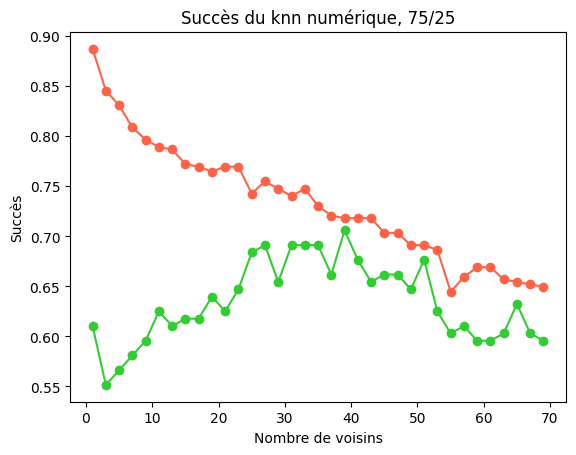

In [43]:
#Graphique du taux de succès par nombre de voisins sur 75 / 25, avec les bonnes numériques

plt.plot([k for k in range(1,71,2)],succes_par_voisin_num(X_train75, Y_train75, X_test25, Y_test25, var_num_bon, 1, 71), marker='o', linestyle='-', color = 'limegreen')
plt.plot([k for k in range(1,71,2)],succes_par_voisin_num(X_train75, Y_train75, X_train75, Y_train75, var_num_bon, 1, 71), marker='o', linestyle='-', color = 'tomato')
plt.title("Succès du knn numérique, 75/25")
plt.xlabel("Nombre de voisins")
plt.ylabel("Succès")
plt.show()

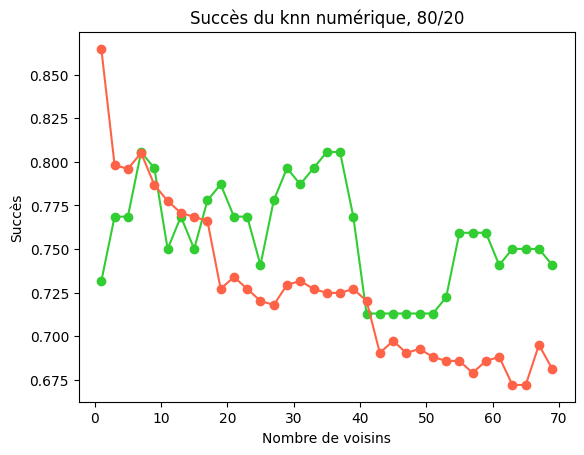

In [44]:
#Graphique du taux de succès par nombre de voisins sur 80 / 20, avec les bonnes numériques

plt.plot([k for k in range(1,71,2)],succes_par_voisin_num(X_train80, Y_train80, X_test20, Y_test20, var_num_bon, 1, 71), marker='o', linestyle='-', color = 'limegreen')
plt.plot([k for k in range(1,71,2)],succes_par_voisin_num(X_train80, Y_train80, X_train80, Y_train80, var_num_bon, 1, 71), marker='o', linestyle='-', color = 'tomato')
plt.title("Succès du knn numérique, 80/20")
plt.xlabel("Nombre de voisins")
plt.ylabel("Succès")
plt.show()

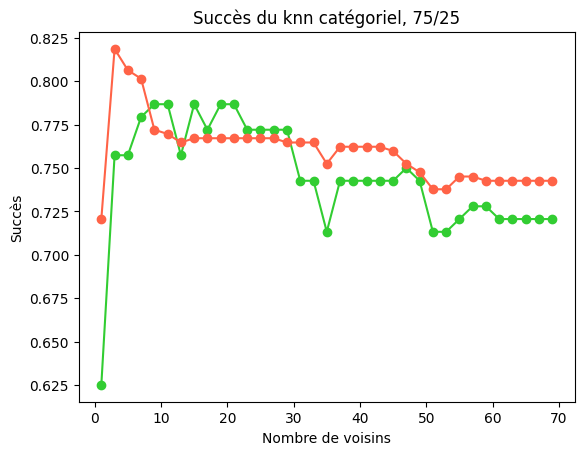

In [45]:
#Graphique du taux de succès par nombre de voisins sur 75 / 25, avec les bonnes catégorielles

plt.plot([k for k in range(1,71,2)],succes_par_voisin_cat(X_train75, Y_train75, X_test25, Y_test25, var_cat_bon, 1, 71), marker='o', linestyle='-', color = 'limegreen')
plt.plot([k for k in range(1,71,2)],succes_par_voisin_cat(X_train75, Y_train75, X_train75, Y_train75, var_cat_bon, 1, 71), marker='o', linestyle='-', color = 'tomato')
plt.title("Succès du knn catégoriel, 75/25")
plt.xlabel("Nombre de voisins")
plt.ylabel("Succès")
plt.show()

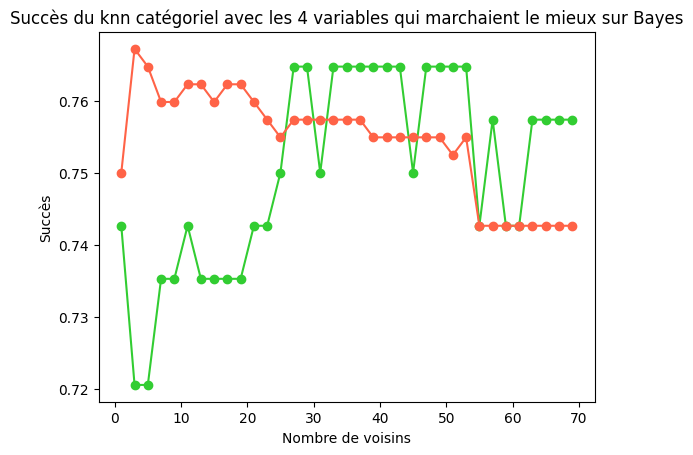

In [46]:
#Graphique du taux de succès par nombre de voisins sur 75 / 25, avec les 4 qui marchaient le mieux pour Bayes

plt.plot([k for k in range(1,71,2)],succes_par_voisin_cat(X_train75, Y_train75, X_test25, Y_test25, var_cat_bay, 1, 71), marker='o', linestyle='-', color = 'limegreen')
plt.plot([k for k in range(1,71,2)],succes_par_voisin_cat(X_train75, Y_train75, X_train75, Y_train75, var_cat_bay, 1, 71), marker='o', linestyle='-', color = 'tomato')
plt.title("Succès du knn catégoriel avec les 4 variables qui marchaient le mieux sur Bayes")
plt.xlabel("Nombre de voisins")
plt.ylabel("Succès")
plt.show()

In [47]:
#Soumission de bayes à partir des bonnes variables catégorielles

prev_bonnes_cat = pd.DataFrame(prev_data, columns = ['classification_diagnostic'])
prev_bonnes_cat['classification_diagnostic'] = knn_cat(X_data_cat, Y_data, X_prev_data_cat, var_cat_bon, 9)
prev_bonnes_cat.to_csv('prev_bonnes_cat92.csv', index = True, index_label = 'ID_ARBRE')

prev_bonnes_cat.head()

,classification_diagnostic
ID_ARBRE,
559,C2
560,C2
561,C2
562,C1
563,C2
